In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import pickle as pkl
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
import gzip


In [4]:
moon_data, moon_labels = datasets.make_moons(1000, noise=0.05)
sigma=0.01
# Compute the adjacency matrix
Adj_mat = squareform(pdist(moon_data, metric='euclidean'))
W = np.exp(-Adj_mat/(2*sigma))
D = np.diag(np.sum(W, axis=1))
L = D - W
D_inv_sqrt = np.diag(1/np.sqrt(np.diag(D)))
mat = np.matmul(np.matmul(D_inv_sqrt, L), D_inv_sqrt)
mat

array([[ 6.94271699e-01, -1.88315890e-33, -2.99384408e-22, ...,
        -1.65307643e-50, -6.42509200e-10, -4.58799237e-55],
       [-1.88315890e-33,  6.16500986e-01, -2.41426038e-32, ...,
        -1.65686462e-22, -1.76332116e-32, -2.03560157e-32],
       [-2.99384408e-22, -2.41426038e-32,  5.65055886e-01, ...,
        -1.44210425e-53, -9.65070186e-30, -4.20014586e-62],
       ...,
       [-1.65307643e-50, -1.65686462e-22, -1.44210425e-53, ...,
         6.08463427e-01, -2.26847505e-46, -1.38743096e-13],
       [-6.42509200e-10, -1.76332116e-32, -9.65070186e-30, ...,
        -2.26847505e-46,  5.63676423e-01, -3.50950205e-49],
       [-4.58799237e-55, -2.03560157e-32, -4.20014586e-62, ...,
        -1.38743096e-13, -3.50950205e-49,  6.36319359e-01]],
      shape=(1000, 1000))

In [6]:
import numpy as np 
from numpy import linalg as la

verbose = 0

def chebyshev_filter(x, m, a, b, a0, A, matvec, matmat, vecvec):
    e = (b-a)/2
    c = (b+a)/2
    s = e/(a0-c)
    s1=s
    y = (np.dot(A,x) - c*x)*(s1/e)
    matvec += 1
    for i in range(1,m):
        s_new = 1/((2/s1)-s)
        y_new = (np.dot(A,y) - c*y)*(2*s_new/e)-((s*s_new)*x)
        matvec += 1
        x=y
        y=y_new
        s=s_new
    return y, matvec, matmat, vecvec

def swapIfNeeded(eigVal, eigVec, matvec, matmat, vecvec):
    mu = eigVal[-1]
    i = eigVal.shape[0]-1
    maxI = i
    while mu < eigVal[i-1]:
        i -= 1
    sortedIndex=list(range(i))+[maxI]+list(range(i,maxI))
    eigVecSortedIndex = sortedIndex
    if eigVec.shape[0]>eigVal.shape[0]:
        eigVecSortedIndex = np.append(sortedIndex,np.array(range(len(eigVal), eigVec.shape[1])))
    return eigVal[sortedIndex], eigVec[:,eigVecSortedIndex], i!=maxI, matvec, matmat, vecvec

def orthonormalizeDGKS(v, M, matvec, matmat, vecvec):
    vnorm = la.norm(v)
    v = v/vnorm
    vnew_norm = None
    eta = 1/np.sqrt(2)
    rndVecIter = 0
    dgksiter = 0
    tmpnorm = eta*vnorm
    while vnew_norm is None or vnew_norm < tmpnorm:
        v_tmp = M.transpose().dot(v)
        matvec += 1
        tmpnorm = la.norm(v_tmp)
        v_new = v - M.dot(v_tmp)
        matvec += 1
        vnew_norm = la.norm(v_new)
        v_new = v_new/vnew_norm
        dgksiter += 1
        if dgksiter > 3:
            print("max dgks iter reached:", vnew_norm, eta*vnorm)
            if rndVecIter < 3:
                rndVecIter += 1
                v =  np.matrix(np.random.randn(v.shape[0])).transpose()
            else:
                raise Exception("DGKS could not orthornormalize after 3 iterations and 3 random vectors")
        else:
            v = v_new
    return v_new, matvec, matmat, vecvec


def lanczos_upperb(A, k, matvec, matmat, vecvec):
    dim = A.shape[0]
    if k == -1:
        k=dim
    T = np.matrix(np.zeros((k, k), dtype=float))

    v_arr = []
    v = np.matrix(np.random.randn(A.shape[0])).transpose()
    v = v/la.norm(v)
    w_prime = A.dot(v)
    matvec += 1
    a = v.transpose().dot(w_prime)[0,0]
    vecvec += 1
    w_new = w_prime - a*v
    v_arr.append(v)
    T[0,0]=a
    for i in range(1,k):
        b=la.norm(w_new)
        if b!=0:
            v_new = w_new/b
            v_arr.append(v_new)
        else:
            v_arr = generate_linearly_independent_unit_vector(v_arr)
            v_new = np.matrix(v_arr[-1]).transpose()
        w_prime = A.dot(v_new)
        matvec += 1
        a = v_new.transpose().dot(w_prime)[0,0]
        w_new = w_prime - a*v_new - b*v
        v=v_new
        T[i,i] = a
        T[i-1, i] = b
        T[i,i-1] = b
    max_eig = max(la.eig(T[:i+1, :i+1])[0])
    if b < 0.01:
        return max_eig+b*10, matvec, matmat, vecvec
    elif b < 0.1:
        return max_eig+b*5, matvec, matmat, vecvec
    else:
        return max_eig+b, matvec, matmat, vecvec
    
    
def getUpperBound(A, matvec, matmat, vecvec):
    nrm_1 = la.norm(A,1)
    l_upperb, matvec, matmat, vecvec = lanczos_upperb(A, 4, matvec, matmat, vecvec)
    return min(nrm_1, l_upperb), matvec, matmat, vecvec
    
def cheb_filtered_subspace(A, kwant, x = None, m=10, kkeep=None, maxdim=None, tol=1e-10, maxIter = 1e3):
    matvec = 0
    matmat = 0
    vecvec = 0
    if x is None:
        x = np.matrix(np.random.randn(A.shape[0])).transpose()
    if kkeep is None:
        kkeep = kwant*2
    if maxdim is None:
        maxdim=kwant*4
        
    eigs = np.array([])
    x = x/la.norm(x)
    V = np.matrix(x)
    w = A.dot(x)
    matvec += 1
    W = np.matrix(w)
    mu = x.transpose().dot(w)[0,0]
    vecvec += 1
    H = np.matrix(mu)
    
    r = w - mu*x
    if la.norm(r,2) <= tol:
        eigs = np.append(eigs, mu)
        kc = 1
        H = np.empty((0,0))
    else:
        kc=0
    upperb, matvec, matmat, vecvec = getUpperBound(A, matvec, matmat, vecvec)
    lowerb = (upperb + mu)/2
    a0 = lowerb
    ksub = 0
    itercount=0
    while itercount < maxIter:
        if verbose > 1:
            print('Upperbound', upperb)
            print('Lowerbound', lowerb)
        t, matvec, matmat, vecvec = chebyshev_filter(x,m,lowerb, upperb, a0, A, matvec, matmat, vecvec)
        v_knext, matvec, matmat, vecvec = orthonormalizeDGKS(t,V[:,0:ksub+1], matvec, matmat, vecvec)
        V = np.column_stack([V, v_knext])
        kold = ksub
        ksub += 1
        w_knext = A.dot(v_knext)
        matvec += 1
        W = np.column_stack([W,w_knext])
        if verbose > 1:
            print('V', V.shape,'W', W.shape,'H', H.shape)
            print('kc:',kc, ',    ksub:',ksub, ',     kold:',kold)        
        #H=np.row_stack([H[:ksub-kc,:ksub-kc],np.zeros(ksub-kc)])
       
        
        
        
        
        
        H=np.row_stack([H,np.zeros(kold+1)])
        if kc>0:
            H=np.column_stack([H,np.row_stack([np.zeros((kc,1)), V[:,kc:ksub+1].transpose().dot(w_knext)])])
            matvec += 1
        else:
            H=np.column_stack([H,V[:,kc:ksub+1].transpose().dot(w_knext)])
            matvec += 1
        for i in range(H.shape[0]-1):
            H[-1,i]=H[i,-1]
        D,Y = la.eigh(H[kc:ksub+1, kc:ksub+1])
        if verbose > 1:
            print('Y',Y)
            print('D',D)
        mu = D[0]
        if ksub >= maxdim:
            if verbose > 0:
                print("INNER RESTART")
            ksub = kc+kkeep
            #H = H[:ksub, :ksub]
            #V = V[:,:ksub]
        if verbose > 0:
            print('kc',kc, '      kold',kold,'         ksub',ksub)
        if kc > 0:
            V = np.column_stack([V[:,:kc], V[:,kc:kold+2].dot(Y[:,:ksub-kc+1])])
            W = np.column_stack([W[:,:kc], W[:,kc:kold+2].dot(Y[:,:ksub-kc+1])])
            matmat += 2
        else:
            V = np.column_stack([V[:,:kc], V[:,kc:kold+2].dot(Y[:,:ksub-kc+1])])
            W = np.column_stack([W[:,:kc], W[:,kc:kold+2].dot(Y[:,:ksub-kc+1])])
            matmat += 2
        if kc>0:
            H = np.column_stack([np.row_stack([H[:kc,:kc],np.zeros((ksub+1-kc,kc))]),np.row_stack([np.zeros((kc,ksub+1-kc)),np.diag(D[:ksub-kc+1])])])
        else:
            H = np.diag(D[:ksub+1])
        r = W[:,kc]-mu*V[:,kc]
        if verbose > 0:
            print('2-norm r',la.norm(r,2))

        itercount +=1
        for conv_i in range(len(D)):
            if verbose > 1:
                print(f'convergenceCheck: norm(r): {la.norm(r,2)}, {tol*max(D[conv_i:])}, V {V.shape}, W {W.shape}, H {H.shape}, norm(H) {la.norm(H,2)}') 
            if la.norm(r,2) <= tol*max(D[conv_i:]):
                kc += 1
                mu = D[conv_i]
                eigs = np.append(eigs,mu)
                if verbose > 0: 
                    print(f"CONVERGED: #{eigs.shape[0]}, in {itercount} steps:",mu)
                ## SWAP TEST and set swap=True if swap happens
                swap = False
                if kc > 1:
                    eigs, V, swap, matmat, vecvec, matvec = swapIfNeeded(eigs, V, matmat, vecvec, matvec)
                    
                if kc >= kwant and not swap:
                    return eigs, V[:,:kc+1], matmat, vecvec, matvec
                mu = D[conv_i+1]
                if kc < V.shape[1]:
                    r = W[:,kc]-mu*V[:,kc]
            else:
                break
        lowerb = np.median(D[:ksub])
        if a0 > min(D):
            a0 = min(D)
        x = V[:,kc]


In [7]:
cheb_filtered_subspace(mat,2)

C:\Users\soura\AppData\Local\Temp\ipykernel_6844\1983505005.py:158: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  H=np.row_stack([H,np.zeros(kold+1)])
C:\Users\soura\AppData\Local\Temp\ipykernel_6844\1983505005.py:160: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  H=np.column_stack([H,np.row_stack([np.zeros((kc,1)), V[:,kc:ksub+1].transpose().dot(w_knext)])])
C:\Users\soura\AppData\Local\Temp\ipykernel_6844\1983505005.py:189: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  H = np.column_stack([np.row_stack([H[:kc,:kc],np.zeros((ksub+1-kc,kc))]),np.row_stack([np.zeros((kc,ksub+1-kc)),np.diag(D[:ksub-kc+1])])])


(array([1.31749967e-18, 1.63735531e-09]),
 matrix([[ 3.32879656e-02, -3.32253718e-02,  2.30641778e-02],
         [ 2.97216518e-02,  2.97775439e-02, -2.41521544e-06],
         [ 2.79086190e-02, -2.78562396e-02,  5.64472493e-02],
         ...,
         [ 2.94150033e-02,  2.94705233e-02,  3.52992588e-05],
         [ 2.78644667e-02, -2.78120062e-02, -3.39804766e-04],
         [ 3.05207342e-02,  3.05784156e-02,  3.00438706e-05]],
        shape=(1000, 3)),
 300,
 2,
 2403)

<>:128: SyntaxWarning: invalid escape sequence '\s'
<>:138: SyntaxWarning: invalid escape sequence '\s'
<>:128: SyntaxWarning: invalid escape sequence '\s'
<>:138: SyntaxWarning: invalid escape sequence '\s'
C:\Users\soura\AppData\Local\Temp\ipykernel_6844\3873856639.py:128: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Fully connected graph with RBF kernel ($\sigma=0.01$)')
C:\Users\soura\AppData\Local\Temp\ipykernel_6844\3873856639.py:138: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Fully connected graph with RBF kernel ($\sigma=0.01$) Chebyshev Davidson')
C:\Users\soura\miniconda3\envs\smu_research\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  

Mat-Mat 302
Vec-Vec 2
Mat-Vec 2419


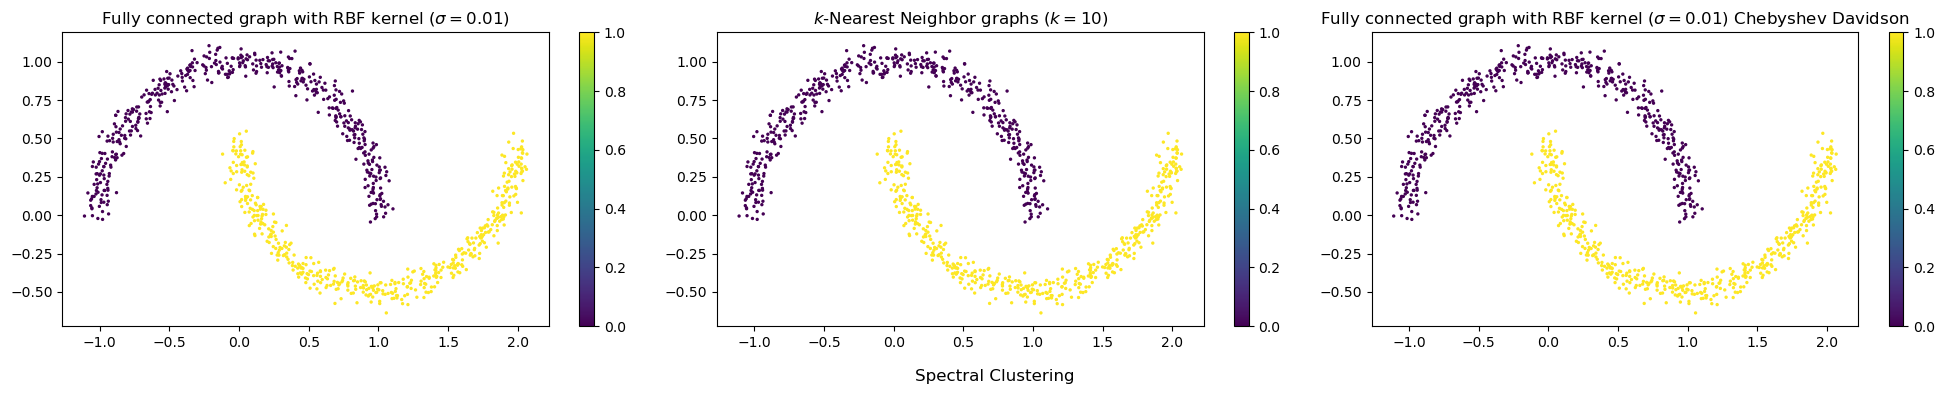

In [9]:
def getEig(mat, eig_algo, k=None):
    if eig_algo == 'np_linalg':
        return np.linalg.eig(mat)
    elif eig_algo == 'cheb_dav':
        #mat = makeHermitianIfBelowFloatErr(mat)
        #checkHermitian(mat,'cheb_dav')
        val, vec, matmat, vecvec, matvec = cheb_filtered_subspace(mat,k)
        print('Mat-Mat',matmat)
        print('Vec-Vec',vecvec)
        print('Mat-Vec',matvec)
        return val, np.asarray(vec)
    else:
        raise Exception ("Invalid Eigen-Algorithm choice. Must be 'np_linalg' or 'cheb_dav'")
        
def Spectral_Clustering(X, K=8, adj=True, metric='euclidean', sim_graph='fully_connect', sigma=1, knn=10, epsi=0.5, normalized=1, eig_algo='np_linalg'):
    '''
    Input: 
        X : [n_samples, n_samples] numpy array if adj=True, or, a [n_samples_a, n_features] array otherwise;
        K: int, The number of clusters;
        adj: boolean, Indicating whether the adjacency matrix is pre-computed. Default: True;
        metric: string, A parameter passing to "scipy.spatial.distance.pdist()" function for computing the adjacency matrix (deprecated if adj=True). Default: 'euclidean';
        sim_graph: string, Specifying the type of similarity graphs. Choices are ['fully_connect', 'eps_neighbor', 'knn', 'mutual_knn']. Default: 'fully_connect';
        sigma: float, The variance for the Gaussian (aka RBF) kernel (Used when sim_graph='fully_connect'). Default: 1;
        knn: int, The number of neighbors used to construct k-Nearest Neighbor graphs (Used when sim_graph='knn' or 'mutual_knn'). Default: 10;
        epsi: float, A parameter controlling the connections between points (Used when sim_graph='eps_neighbor'). Default: 0.5;
        normalized: int, 1: Random Walk normalized version; 2: Graph cut normalized version; other integer values: Unnormalized version. Default: 1.
    Output:
        sklearn.cluster class, Attributes:
            cluster_centers_ : array, [n_clusters, n_features], Coordinates of cluster centers in K-means;
            labels_ : Labels of each point;
            inertia_ : float, Sum of squared distances of samples to their closest cluster center in K-means;
            n_iter_ : int, Number of iterations run in K-means.
    '''
    # Compute the adjacency matrix
    if not adj:
        Adj_mat = squareform(pdist(X, metric=metric))
    else:
        Adj_mat = X
    # Compute the weighted adjacency matrix based on the type of similarity graphs
    if sim_graph ==  'fully_connect':
        W = np.exp(-Adj_mat/(2*sigma))
    elif sim_graph == 'eps_neighbor':
        W = (Adj_mat <= epsi).astype('float64')
    elif sim_graph == 'knn':
        W = np.zeros(Adj_mat.shape)
        # Sort the adjacency matrx by rows and record the indices
        Adj_sort = np.argsort(Adj_mat, axis=1)
        # Set the weight (i,j) to 1 when either i or j is within the k-nearest neighbors of each other
        for i in range(Adj_sort.shape[0]):
            W[i,Adj_sort[i,:][:(knn+1)]] = 1
    elif sim_graph == 'mutual_knn':
        W1 = np.zeros(Adj_mat.shape)
        # Sort the adjacency matrx by rows and record the indices
        Adj_sort = np.argsort(Adj_mat, axis=1)
        # Set the weight W1[i,j] to 0.5 when either i or j is within the k-nearest neighbors of each other (Flag)
        # Set the weight W1[i,j] to 1 when both i and j are within the k-nearest neighbors of each other
        for i in range(Adj_mat.shape[0]):
            for j in Adj_sort[i,:][:(knn+1)]:
                if i == j:
                    W1[i,i] = 1
                elif W1[i,j] == 0 and W1[j,i] == 0:
                    W1[i,j] = 0.5
                else:
                    W1[i,j] = W1[j,i] = 1
        W = np.copy((W1 > 0.5).astype('float64'))
    elif sim_graph == 'raw': #Use adjacency matrix as affinity matrix
        W = Adj_mat
    else:
        raise ValueError("The 'sim_graph' argument should be one of the strings, 'fully_connect', 'eps_neighbor', 'knn', or 'mutual_knn'!")
        
    # Compute the degree matrix and the unnormalized graph Laplacian
    D = np.diag(np.sum(W, axis=1))
    L = D - W
    # Compute the matrix with the first K eigenvectors as columns based on the normalized type of L
    if normalized == 1:   ## Random Walk normalized version
        # Compute the inverse of the diagonal matrix
        D_inv = np.diag(1/np.diag(D))
        # Compute the eigenpairs of L_{rw}
        mat = np.dot(D_inv, L)
        #checkHermitian(mat,'L_rw')
        #mat = makeHermitianIfBelowFloatErr(mat)
        #writeMatrix(W, 'W.mat')
        #checkHermitian(mat,'L_rw')

        Lambdas, V = getEig(mat, eig_algo, k=K)
        # Sort the eigenvalues by their L2 norms and record the indices
        ind = np.argsort(np.linalg.norm(np.reshape(Lambdas, (1, len(Lambdas))), axis=0))
        V_K = np.real(V[:, ind[:K]])
    elif normalized == 2:   ## Graph cut normalized version
        # Compute the square root of the inverse of the diagonal matrix
        D_inv_sqrt = np.diag(1/np.sqrt(np.diag(D)))
        # Compute the eigenpairs of L_{sym}
        Lambdas, V = getEig(np.matmul(np.matmul(D_inv_sqrt, L), D_inv_sqrt), eig_algo, k=K)
        # Sort the eigenvalues by their L2 norms and record the indices
        ind = np.argsort(np.linalg.norm(np.reshape(Lambdas, (1, len(Lambdas))), axis=0))
        V_K = np.real(V[:, ind[:K]])
        if any(V_K.sum(axis=1) == 0):
            raise ValueError("Can't normalize the matrix with the first K eigenvectors as columns! Perhaps the number of clusters K or the number of neighbors in k-NN is too small.")
        # Normalize the row sums to have norm 1
        V_K = V_K/np.reshape(np.linalg.norm(V_K, axis=1), (V_K.shape[0], 1))
    else:   ## Unnormalized version
        # Compute the eigenpairs of L
        Lambdas, V = getEig(L, eig_algo, k=K)
        # Sort the eigenvalues by their L2 norms and record the indices
        ind = np.argsort(np.linalg.norm(np.reshape(Lambdas, (1, len(Lambdas))), axis=0))
        V_K = np.real(V[:, ind[:K]])
        
    # Conduct K-Means on the matrix with the first K eigenvectors as columns
    kmeans = KMeans(n_clusters=K, init='k-means++', random_state=0).fit(V_K)
    return kmeans


def main():
    # Generate a toy dataset...
    moon_data, moon_labels = datasets.make_moons(1000, noise=0.05)
    # Compute the adjacency matrix
    Adj_mat = squareform(pdist(moon_data, metric='euclidean'))
    # Spectral clustering...
    spec_re1 = Spectral_Clustering(Adj_mat, K=2, sim_graph='fully_connect', sigma=0.01, normalized=0)
    spec_re2 = Spectral_Clustering(Adj_mat, K=2, sim_graph='knn', knn=10, normalized=1)
    spec_re3 = Spectral_Clustering(Adj_mat, K=2, sim_graph='fully_connect', sigma=0.01, normalized=2, eig_algo='cheb_dav')

    # Often need to change figsize when doing subplots
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 3, 1)
    plt.scatter(x=moon_data[:, 0], y=moon_data[:, 1], c=spec_re1.labels_, s=2)
    plt.colorbar()
    plt.title('Fully connected graph with RBF kernel ($\sigma=0.01$)')

    plt.subplot(1, 3, 2)
    plt.scatter(x=moon_data[:, 0], y=moon_data[:, 1], c=spec_re2.labels_, s=2)
    plt.colorbar()
    plt.title('$k$-Nearest Neighbor graphs ($k=10$)')

    plt.subplot(1, 3, 3)
    plt.scatter(x=moon_data[:, 0], y=moon_data[:, 1], c=spec_re3.labels_, s=2)
    plt.colorbar()
    plt.title('Fully connected graph with RBF kernel ($\sigma=0.01$) Chebyshev Davidson')

    plt.suptitle('Spectral Clustering', y=-0.01)

    # Automatrically adjust padding between subpots 
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    main()    